# AP(P)3RO PROJECT #

### Projet de deneigement intelligent de Montréal, Canada ###

#### M. Le Gras, A. Naullet, A. Calixte, P. Beaunieux ####

In [1]:
import multiprocessing as mp
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import osmnx as ox
import networkx as nx

## Deneigement de la ville de Montréal ##

<h4>Rappel Objectif:</h4> 
Les deneigeuses vont devoir se repartir la tache pour parcourir Montréal et tout deneiger

Ceci s'apparente donc au calcul d'un chemin Eulerien du graphe (orienté) correspond à Montréal

In [91]:
place = "Montreal, Canada" 
G = ox.graph_from_place(place, network_type="walk")

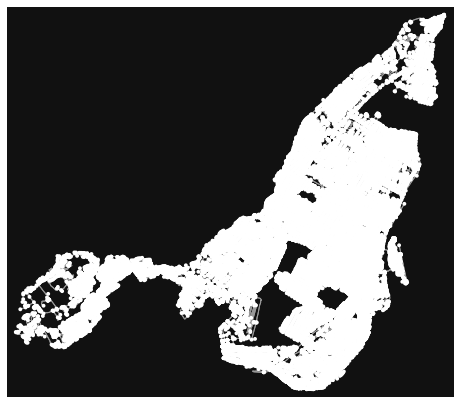

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [92]:
ox.plot_graph(G)

On va réutiliser nos sous-parties de Montréal vues dans la partie sur les drones puis les rediviser en sous-graphes pour bien repartir le travail des deneigeuses.

In [93]:
G1 = ox.truncate.truncate_graph_dist(G,8753159525,max_dist=8000) #C
G2 = ox.truncate.truncate_graph_dist(G,300155692,max_dist=6000) #L
G3 = ox.truncate.truncate_graph_dist(G,1364932818,max_dist=3300) #F
G4 = ox.truncate.truncate_graph_dist(G,32675009,max_dist=5800) #D
G5 = ox.truncate.truncate_graph_dist(G,213784080,max_dist=3400) #G
G6 = ox.truncate.truncate_graph_dist(G,246285242,max_dist=5000) #I
G7 = ox.truncate.truncate_graph_dist(G,26234647,max_dist=5000) #Ile
G8 = ox.truncate.truncate_graph_dist(G,588566218,max_dist=6000) #B
G9 = ox.truncate.truncate_graph_dist(G,8586746933,max_dist=11000) #A
G10 = ox.truncate.truncate_graph_dist(G,583470197,max_dist=5700) #K
G11 = ox.truncate.truncate_graph_dist(G,31630568,max_dist=3200) # J
G12 = ox.truncate.truncate_graph_dist(G,294966935,max_dist=10200) #M
G13 = ox.truncate.truncate_graph_dist(G,29784717,max_dist=3400) #Donut
G14 = ox.truncate.truncate_graph_dist(G,310090260,max_dist=2600) #mid
G15 = ox.truncate.truncate_graph_dist(G,258812508,max_dist=6500) #orel_zone

In [94]:
def to_graph_city(GG):
    node_list = list(GG.edges(data=True))
    graph_city = []
    for node in node_list:
        n1 = node[0]
        n2 = node[1]
        dist = node[2]["length"]
        
        
        is_oneway = node[2]["oneway"] #Ajout de la composante "orienté" du graph
        if not (is_oneway):
            graph_city.append((n2,n1,dist))
            
        graph_city.append((n1,n2,dist))
    return graph_city

In [95]:
g_city = to_graph_city(G)
print("There are %d edges" % len(g_city))

There are 352532 edges


In [96]:
def to_gnx(graph_city):
    gnx = nx.Graph()
    for (a,b,c) in graph_city:
        gnx.add_edge(a,b, weight=c)
    return gnx

Gnx = to_gnx(g_city)

## Division en sous graphes

On décide d'utiliser un algorithme qui sépare en Deux un graphe. Puis on va réiterer sur cette algorithme jusqu'à obtenir le nombre de sous-graphes désiré.

In [97]:


def edge_to_remove(graph):
    G_dict = nx.edge_betweenness_centrality(graph)
    edge = ()

    # extract the edge with highest edge betweenness centrality score
    for key, value in sorted(G_dict.items(), key=lambda item: item[1], reverse = True):
        edge = key
        break
  
    return edge

def girvan_newman(graph):
    # find number of connected components
    sg = nx.connected_components(graph)
    sg_count = nx.number_connected_components(graph)

    clear = '\x08' * (30)
    while(sg_count == 1):
        print("\r[-] Trying to split graph", flush=True, end="")
        print(clear,end="")
        print("\r[-] Trying to split graph.", flush=True, end="")
        graph.remove_edge(edge_to_remove(graph)[0], edge_to_remove(graph)[1])
        print("\r[-] Trying to split graph..", flush=True, end="")
        sg = nx.connected_components(graph)
        print("\r[-] Trying to split graph...", flush=True, end="")
        sg_count = nx.number_connected_components(graph)
    print()
    return sg

'''
return  all found edges from node list and Gnx edges
'''
def node_list_to_graph(node_l, Gnx_edges):
    edge_list = []
    for node1 in node_l:
        for node2 in node_l:
            if (node1,node2) in Gnx_edges:
                edge_list.append((node1,node2,Gnx_edges[(node1,node2)]["weight"]))
    return edge_list

def split_graph_in_two(Gnx, Gnx_edges):
    c = girvan_newman(Gnx.copy())
    print("[+] spliting done")
    node_groups = []
    for i in c:
        node_groups.append(list(i))
    
    graph1 = node_list_to_graph(node_groups[0],Gnx_edges) 
    graph2 = node_list_to_graph(node_groups[1],Gnx_edges)
    
    return (graph1,graph2)

In [98]:
import sys
sys.path.append("./scripts")
import importlib as iplib
import oriented_path

update = iplib.reload(oriented_path)

Les fonctions ci-dessous ne sont que des wrappers sur les fonctions scriptée et importées au dessus.

(Les scripts importés correspondent à ceux décrits et utilisés dans la partie démo.)

In [99]:

'''
Split in maximum n sub-graphs. Utile pour separer la ville en fonction du nombre de machines disponible.
'''
def split_in_n_graph(Gnx,n):
    Gnx_edges = Gnx.edges
    count = 1
    sub_graph_list = [Gnx]
    sub_graph_res = [None]
    while (count < n):
        graph = sub_graph_list.pop(0)
        (g1,g2) = split_graph_in_two(graph, Gnx_edges)
        
        if (len(g1) != 0):
            sub_graph_list.append(to_gnx(g1))
            sub_graph_res.append(g1)
        if (len(g2) != 0):
            sub_graph_list.append(to_gnx(g2))
            sub_graph_res.append(g2)
        
        sub_graph_res.pop(0)
            
        count += 1
    print("[+] Done spliting")
    return sub_graph_res




'''
retourne le chemin "couvrant" de chaque sous partie de la ville Et une liste de couleur pour osmnx
'''
def get_all_path(graph_list):
    color_list = []
    path_list  = []
    
    for g in graph_list:
        if not (len(g)):
            continue
        path_list.append(oriented_path.get_best_path(g))
        new_color = '#%02x%02x%02x' % (tuple(np.random.choice(range(256), size=3)))
        color_list.append(new_color)
    return (color_list, path_list)

## Demo sur une Sous Partie:

Vous montrer cette partie sur la totalité des sous-graphes de Montréal serait tres redondant, c'est pourquoi nous allons faire l'exemple sur une seule sous-partie.

Evidement le fonctionnement serait le même pour toutes les sous-parties de Montréal.

Voici donc la sous partie sur laquelle nous allons travailler pour la demonstration. (G12)

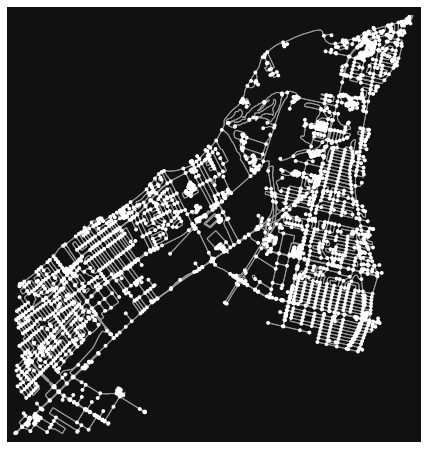

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [105]:
ox.plot_graph(G12)

In [100]:
g12_city = to_graph_city(G12)
Gnx12 = to_gnx(g12_city)

Nous avons 2200 machines disponible. C'est à dire envirron 1100 Deneigeuses routes et 1100 deneigeuses trotoire.

En partant du principe que elle vont de pair et que nous avons 15 sous parties de Montréal, cela fait (1100/15 = 73) paires de machines par sous-parties


On va pouvoir essayer de rediviser en 73 sous-graphes chaque graphe représentant une sous-partie de la ville.

Le calcul durant envrirron 35 min, vous avez egalement la possibilité de charger le resultat de la séparation en sous-graphes préalablement calculer. <br>
Ils vous suffirait alors d'utiliser la variable ci-dessous: <brg12_sub_graphs</b>

In [106]:
#- - -Possibilité de chargés les sous-graphs déja calculés pour G12
import sys
sys.path.append('./old_sub_graphs')
from g12_sub_graphs import *
# La variable g12_sub_graphs correspond à la liste des sous graphs déja calculé pour G12

Pour recapituler l'algorithme ci-dessous va:

### Etape 1:
Essayer de separer en N sous-graphes le graphe donner en paramètre.


### Etape 2:
Verifier combien de graphes ont réussis à être créés

### Etape 3:
Utiliser l'algorithme vu dans la partie Démo pour calculer un chemin pour chacun des sous-graphes trouvés juste avant.

In [101]:

#Envirron 30-40 min de Calcul pour une sous-partie
#Un peu long mais une fois calculé, il n'y a plus besoin de le refaire si on sauvegarde tous les sous-graphes comme le fait la démo avec les sous-graphes de G12
#On pourrait considérer que seuls les chemins de "parcours" des sous-graphs sont à re-calculer en fonction du niveau de chutte de neige

MAX_SUB_PARTS = 73
graph_list = split_in_n_graph(Gnx12,MAX_SUB_PARTS) 
#graph_list = g12_sub_graphs (si on veut utiliser la variable pré-chargés provenant des sauvegardes)

print("[*] Maximum spliting ask: %d" % MAX_SUB_PARTS)
print("[+] The graph is now subdivided in %d parts" % (len(graph_list)))

(colors,paths) = get_all_path(graph_list)

[-] Trying to split graph...
[+] spliting done
[-] Trying to split graph...
[+] spliting done
[-] Trying to split graph...
[+] spliting done
[-] Trying to split graph...
[+] spliting done
[-] Trying to split graph...
[+] spliting done
[-] Trying to split graph...
[+] spliting done
[-] Trying to split graph...
[+] spliting done
[-] Trying to split graph...
[+] spliting done
[-] Trying to split graph...
[+] spliting done
[-] Trying to split graph...
[+] spliting done
[-] Trying to split graph...
[+] spliting done
[-] Trying to split graph...
[+] spliting done
[-] Trying to split graph...
[+] spliting done
[-] Trying to split graph...
[+] spliting done
[-] Trying to split graph...
[+] spliting done
[-] Trying to split graph...
[+] spliting done
[-] Trying to split graph...
[+] spliting done
[-] Trying to split graph...
[+] spliting done
[-] Trying to split graph...
[+] spliting done
[-] Trying to split graph...
[+] spliting done
[-] Trying to split graph...
[+] spliting done
[-] Trying to

Block ci-dessous pour chargés les chemins en sauvegarde.

In [104]:
#- - - Backup: G12 (decommenter pour ecraser une sauvegarde des sous graphs de G12  )
#g12_sub_graphs = graph_list
#open("old_sub_graphs/g12_sub_graphs.py", "w").write("g12_sub_graphs = " + str(g12_sub_graphs))

254820

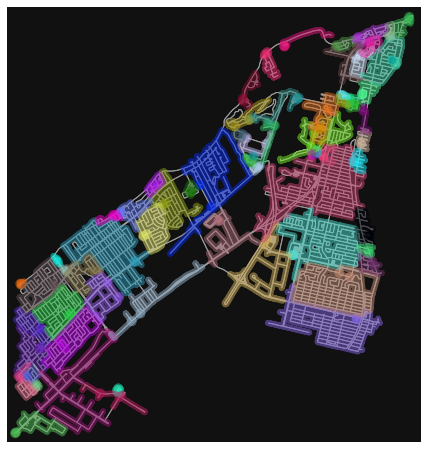

In [102]:
fig, ax = ox.plot_graph_routes(G12, paths, route_colors=colors,route_linewidth=6, node_size=0)
#fig, ax = ox.plot_graph_route(G, [2154711848,2154711882],route_linewidth=6, node_size=0)

Vous pouvez voir si dessus les différents parcours associés a chaque deneigeuse pour la sous partie (G12) de Montréal.

NB: ils sont accessibles dans la variable "paths"
<br>-> print(paths) pour les afficher

In [109]:
#print(paths)